# **Notebook 6: Regression**

## Objectives

* Fit and evaluate a regression model to predict prices on houses.

## Inputs

* outputs/datasets/collection/house_prices_records.csv
* Instructions on which features to use for data cleaning and feature engineering can be found in respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/housing'

# Step 1: Load data

Here we load the dataset and separate the target variable ('y') from the predictor variables ('X').



In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv"))

# Separate predictors and target
X = df.drop(['SalePrice'], axis=1)
y = df['SalePrice']

print(X.shape)
X.head(3)

(1460, 23)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,8450,65.0,196.0,61,5,7,856,0.0,2003,2003
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,9600,80.0,0.0,0,8,6,1262,NaN,1976,1976
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,11250,68.0,162.0,42,5,7,920,NaN,2001,2002


---

# ML Pipeline: Regressor

## Create ML pipeline for Data Cleaning, Feature Engineering, feature scaling, modelling and hyperparameter optimization

In [6]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.selection import DropFeatures
from sklearn.base import BaseEstimator, TransformerMixin

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


class ConvertToInt64(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in self.columns:
            X[col] = X[col].astype('Int64')
        return X

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        
        ("ConvertToInt64", ConvertToInt64(columns=['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea'])),
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        
        ("MedianImputer", MeanMedianImputer(imputation_method='median', 
                                             variables=['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea'])),
        
        ("CategoricalImputer", CategoricalImputer(variables=['BsmtFinType1', 'GarageFinish'])),
        
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        
        ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['1stFlrSF', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage'])),
        
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),
    ])

    return pipeline_base
    

Custom Class for Hyperparameter Optimisation

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Grid Search CV - Sklearn

Use standard hyperparameters to find most suitable algorithm

In [9]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a hyperparameter optimisation search using default hyperparameters

In [10]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)



Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.643677,0.773052,0.833795,0.067359
3,ExtraTreesRegressor,0.680311,0.761302,0.792766,0.041871
2,RandomForestRegressor,0.61857,0.752879,0.821975,0.070098
0,LinearRegression,0.710065,0.750944,0.820973,0.037733
6,XGBRegressor,0.637822,0.674272,0.705139,0.025922
4,AdaBoostRegressor,0.507364,0.660561,0.745273,0.086191
1,DecisionTreeRegressor,0.352237,0.527826,0.646729,0.10588


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search
* NB: The reason ExtraTreesRegressor is not included here despite having the second highest R^2 score is as folllows. When looking at metrics, it appeared that the model performed well on the train set (marginally better than GradientBoostingRegressor), as indicated by low values of MAE, MSE, and RMSE, and a high value of R^2. However, there was a noticeable drop in performance on the test set, as indicated by higher values of MAE, MSE, and RMSE, and a lower value of R^2. This suggests that the model may have been overfitting the training data and not generalizing well to unseen data. Therefore I have chosen two models with better fit here.

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params_search = {
        "GradientBoostingRegressor": {
        'model__learning_rate': [1e-1,1e-2,1e-3],
        'model__max_depth': [3,10,None],
        'model__n_estimators': [100, 300],
    },
    "RandomForestRegressor": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
    },
}

Extensive GridSearch CV

In [48]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Check results

Here we get a summary table showing the results from the GridSearchCV operation. It includes the mean_score, which we can use to compare the performance of different hyperparameters configurations. Since we are looking at R^2 score, the one with the highest mean_score would be the optimal choice.

In [49]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators,model__min_samples_leaf,model__min_samples_split
0,GradientBoostingRegressor,0.643677,0.773052,0.833795,0.067359,0.1,3,100,NaN,NaN
7,GradientBoostingRegressor,0.700466,0.772586,0.817202,0.046327,0.01,3,300,NaN,NaN
40,RandomForestRegressor,0.662516,0.761972,0.823215,0.054461,NaN,None,100,2,5
38,RandomForestRegressor,0.661189,0.761253,0.8245,0.054828,NaN,None,100,2,2
41,RandomForestRegressor,0.667339,0.761213,0.821311,0.052513,NaN,None,200,2,5
39,RandomForestRegressor,0.666472,0.760649,0.82126,0.052401,NaN,None,200,2,2
1,GradientBoostingRegressor,0.60314,0.758791,0.822982,0.079614,0.1,3,300,NaN,NaN
37,RandomForestRegressor,0.641299,0.757999,0.819964,0.061716,NaN,None,200,1,5
36,RandomForestRegressor,0.637756,0.757584,0.823037,0.063744,NaN,None,100,1,5
35,RandomForestRegressor,0.631645,0.756111,0.821596,0.065181,NaN,None,200,1,2


Check the best model

In [50]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [51]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

Get the complete pipeline of the best model, including all preprocessing steps and the estimator itself, with the parameters set to their optimal values:

In [52]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('ConvertToInt64',
                 ConvertToInt64(columns=['2ndFlrSF', 'BedroomAbvGr',
                                         'GarageYrBlt', 'LotFrontage',
                                         'MasVnrArea'])),
                ('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('MedianImputer',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('CategoricalImputer',
                 Categ...
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQ

## Assess feature importance

In [ ]:
X_train.head(3)

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


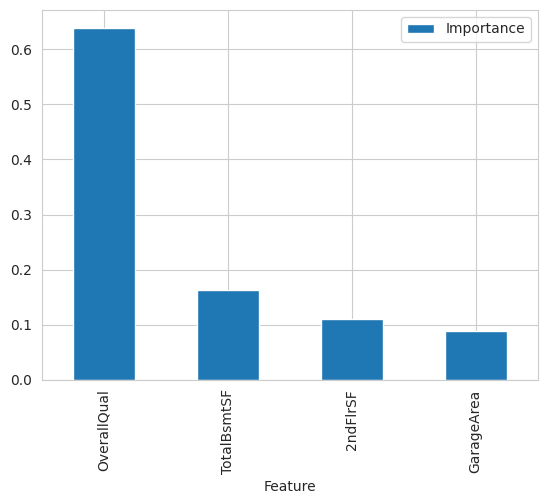

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 7 #these are the number of feature engineering and data cleaning steps in the pipeline
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Pipeline on Train and Test Sets

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()



Model Evaluation 

* Train Set
R2 Score: 0.906
Mean Absolute Error: 17783.587
Mean Squared Error: 580749250.131
Root Mean Squared Error: 24098.74


* Test Set
R2 Score: 0.832
Mean Absolute Error: 22484.658
Mean Squared Error: 1158042518.86
Root Mean Squared Error: 34030.024




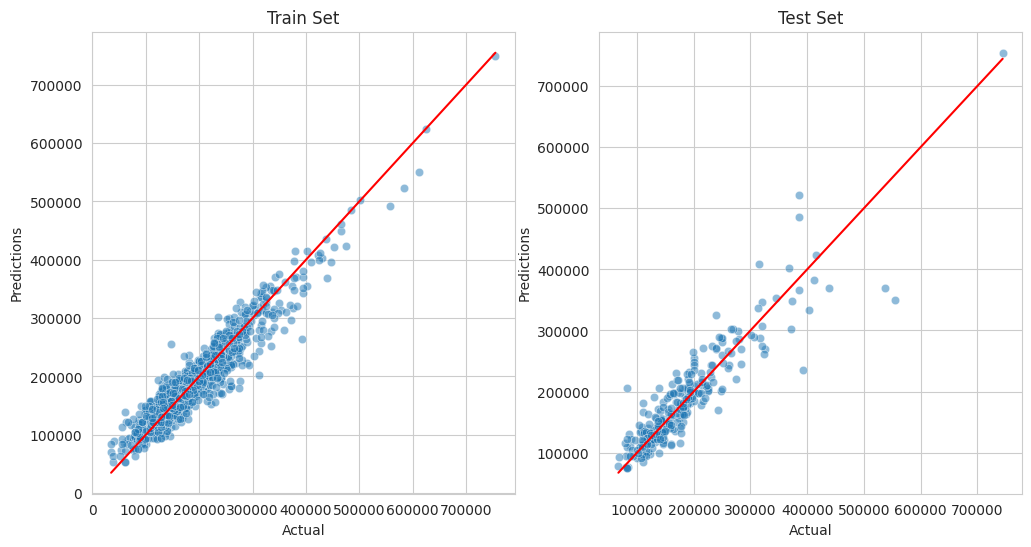

In [55]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# The function regression_performance prints out the regression metrics 
# for our training and test datasets using the pipeline we trained.

Overall, these results indicate that the model is performing well, with relatively low MAE values and high R-squared scores, indicating good accuracy and fit to the data. As well, there is low discrepancy between R^2 score between train and test sets, indicating the model does not under or overfit the data.

# Step 3: Refit pipeline with best features

## Refit ML Pipeline and Resampling

In theory, a pipeline fitted **using only the most important features** should give the same result as the one fitted with **all variables and feature selection**

* However, in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE().

## Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [61]:
best_features

Index(['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea'], dtype='object')

New Pipeline for DataCleaning And FeatureEngineering

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

class ConvertToInt64(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in self.columns:
            X[col] = X[col].astype('Int64')
        return X

def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("ConvertToInt64", ConvertToInt64(columns=['2ndFlrSF'])),        
        ("MedianImputer", MeanMedianImputer(imputation_method='median', 
                                             variables=['2ndFlrSF'])),
        ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['TotalBsmtSF', 'GarageArea'])),
    ])

    return pipeline_base

PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('ConvertToInt64', ConvertToInt64(columns=['2ndFlrSF'])),
                ('MedianImputer', MeanMedianImputer(variables=['2ndFlrSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['TotalBsmtSF',
                                                  'GarageArea']))])

## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [63]:
def PipelineReg(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

## Split Train Test Set, considering only with best features


In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


We filter only the most important variables

In [65]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(1168, 4) (1168,) (292, 4) (292,)


,OverallQual,TotalBsmtSF,2ndFlrSF,GarageArea
618,9,1822,0.0,774
870,5,894,0.0,308
92,5,876,0.0,432


## Fit pipeline (no target imbalance)

In [66]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 4) (292, 4) (1168,) (292,)


## Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from  the last GridCV search

In [67]:
# previously this variable contained two models
# we are redefining the variable here to only include the best model that we chose
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}
models_search

{'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0)}

And the best parameters from the last GridCV search 

In [68]:
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [69]:
params_search = {
    'GradientBoostingRegressor': {
        'model__learning_rate': [0.1],   
        'model__max_depth': [3],
        'model__n_estimators': [100]
    }
}
params_search

{'GradientBoostingRegressor': {'model__learning_rate': [0.1],
  'model__max_depth': [3],
  'model__n_estimators': [100]}}

GridSearch CV

In [70]:
from sklearn.metrics import make_scorer, mean_absolute_error

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train, scoring=scorer, n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [71]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
0,GradientBoostingRegressor,-26020.676424,-23592.921371,-20886.337574,1825.548031,0.1,3,100


The numbers above are very close to the previous results.

Define the best rgr pipeline

In [72]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_rgr = grid_search_pipelines[best_model].best_estimator_
pipeline_rgr

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingRegressor(random_state=0))])

## Assess feature importance

In [23]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_rgr['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

ValueError: The number of columns in this dataset is different from the one used to fit this transformer (when using the fit() method).

## Evaluate Pipeline on Train and Test Sets

Evaluation: We cross-check with metrics defined in the ML business case.
* 80% Recall for Churn, on train and test set.
* 80% Precision for no Churn on train and test set. 

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_metrics(X, y, pipeline):
    prediction = pipeline.predict(X)

    print('---  Regression Metrics  ---')
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y, prediction)}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y, prediction)}")
    print(f"Root Mean Squared Error (RMSE): {mean_squared_error(y, prediction, squared=False)}")
    print(f"R-squared (R^2): {r2_score(y, prediction)}")

def reg_performance(X_train, y_train, X_test, y_test, pipeline):
    print("#### Train Set #### \n")
    regression_metrics(X_train, y_train, pipeline)

    print("\n#### Test Set ####\n")
    regression_metrics(X_test, y_test, pipeline)

In [75]:
reg_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_rgr)

# The function reg_performance prints out the regression metrics 
# for our training and test datasets using the pipeline we trained.

#### Train Set #### 

---  Regression Metrics  ---
Mean Absolute Error (MAE): 17783.586852843655
Mean Squared Error (MSE): 580749250.1311158
Root Mean Squared Error (RMSE): 24098.739596317395
R-squared (R^2): 0.905675977685939

#### Test Set ####

---  Regression Metrics  ---
Mean Absolute Error (MAE): 22559.90207960311
Mean Squared Error (MSE): 1174203230.4839911
Root Mean Squared Error (RMSE): 34266.64895323135
R-squared (R^2): 0.8299697739446306


The results show only marginal differences for the test set, in comparison to previous model fitted on all features.

# Step 4: push files to repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [46]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_housing/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Train Set

In [47]:
print(X_train.shape)
X_train.head()

(1168, 4)


,OverallQual,TotalBsmtSF,2ndFlrSF,GarageArea
618,9,495.850351,0,285.045723
870,5,280.785318,0,133.391173
92,5,276.257124,0,176.329005
817,8,439.843394,0,309.970775
302,7,433.785653,0,305.798023


In [48]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [49]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [50]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* note that the variables are transformed already in X_test

In [51]:
print(X_test.shape)
X_test.head()

(292, 4)


,OverallQual,TotalBsmtSF,2ndFlrSF,GarageArea
529,6,541.596143,0,193.645231
491,6,258.462952,620,108.556198
459,5,233.273633,224,148.929238
279,7,345.753788,866,200.542297
655,6,183.422323,0,117.449491


In [52]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [53]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [54]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_rgr, since the data is already processed.



Pipeline responsible for Data Cleaning and Feature Engineering.

In [76]:
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('ConvertToInt64', ConvertToInt64(columns=['2ndFlrSF'])),
                ('MedianImputer', MeanMedianImputer(variables=['2ndFlrSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['TotalBsmtSF',
                                                  'GarageArea']))])

In [77]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/rgr_pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_housing/v1/rgr_pipeline_data_cleaning_feat_eng.pkl']

* Pipeline responsible for Feature Scaling, and Model

In [57]:
pipeline_rgr

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingRegressor(random_state=0))])

In [58]:
joblib.dump(value=pipeline_rgr ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_housing/v1/clf_pipeline_model.pkl']

## Feature Importance plot

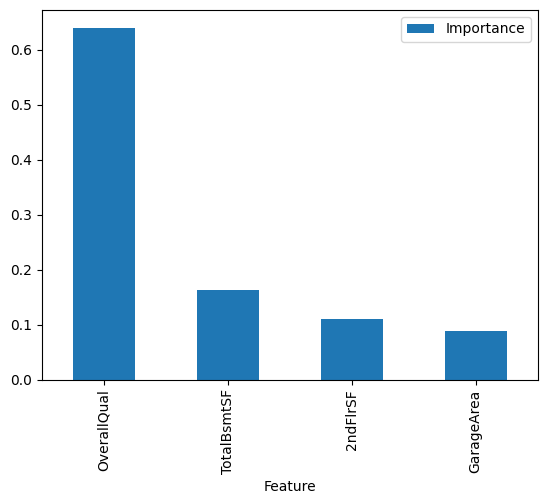

In [59]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

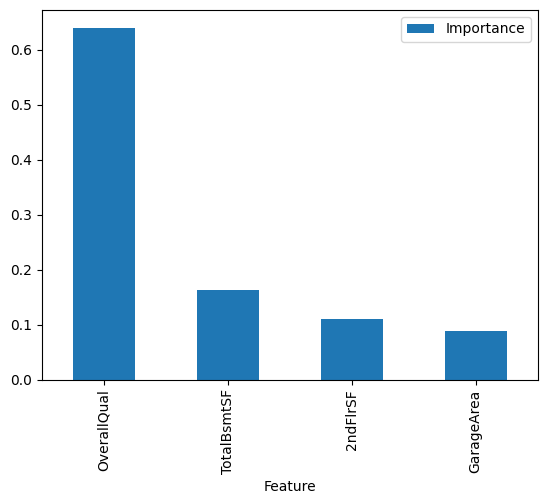

In [60]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job, you should clear outputs, then run git commands to push files to the repo. Next, move on to Predict Tenure notebook

---